# Backpropagation algorithm

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from IPython.display import display
import datetime as dt 
import random
from back_prop_utils import H_th_function, grid_search, round_to_sig_figs
from loss_functions import loss
from models import TransferFunctionModel
from plotting_utils import plot_training_progress

In [2]:
# frequency range
interp = 2**6
freqs_THz = np.linspace(0.1, 5, interp)   # 0-5 THz 
freqs = freqs_THz * 1e12
freqs_ang = freqs * 2 * np.pi 
w_tensor = torch.tensor(freqs_ang, dtype=torch.float32)

# Generate random n, k, d
n_lims = [2, 4]
k_lims = [-0.1, -1e-6]
d_lims = [300e-6, 600e-6]

# Define significant figures for each parameter
n_sig_figs = 6
k_sig_figs = 6
d_sig_figs = 6

# Generate data point

n = random.uniform(*n_lims)
k = random.uniform(*k_lims)
d = random.uniform(*d_lims)

"""
# Test specific values for n,k,d
n = 3.9
k = -0.001
d = 499e-6 
"""

# Apply significant figures
n_actual = round_to_sig_figs(n, n_sig_figs)
k_actual = round_to_sig_figs(k, k_sig_figs)
d_actual = round_to_sig_figs(d, d_sig_figs)

tf_values = H_th_function((n_actual+k_actual*1j), w_tensor, d_actual)  # Use torch tensor for w

H_values_clean = np.abs(tf_values)
phi_values_clean = np.unwrap(np.angle(tf_values))
phi_exp_tensor = torch.tensor(phi_values_clean, dtype=torch.float32) # convert back to tensor

# add noise or actual signals
H_values = H_values_clean + np.random.normal(0, 0.005, size=len(H_values_clean))
phi_values = phi_exp_tensor + np.random.normal(0, 1, size=len(phi_values_clean))

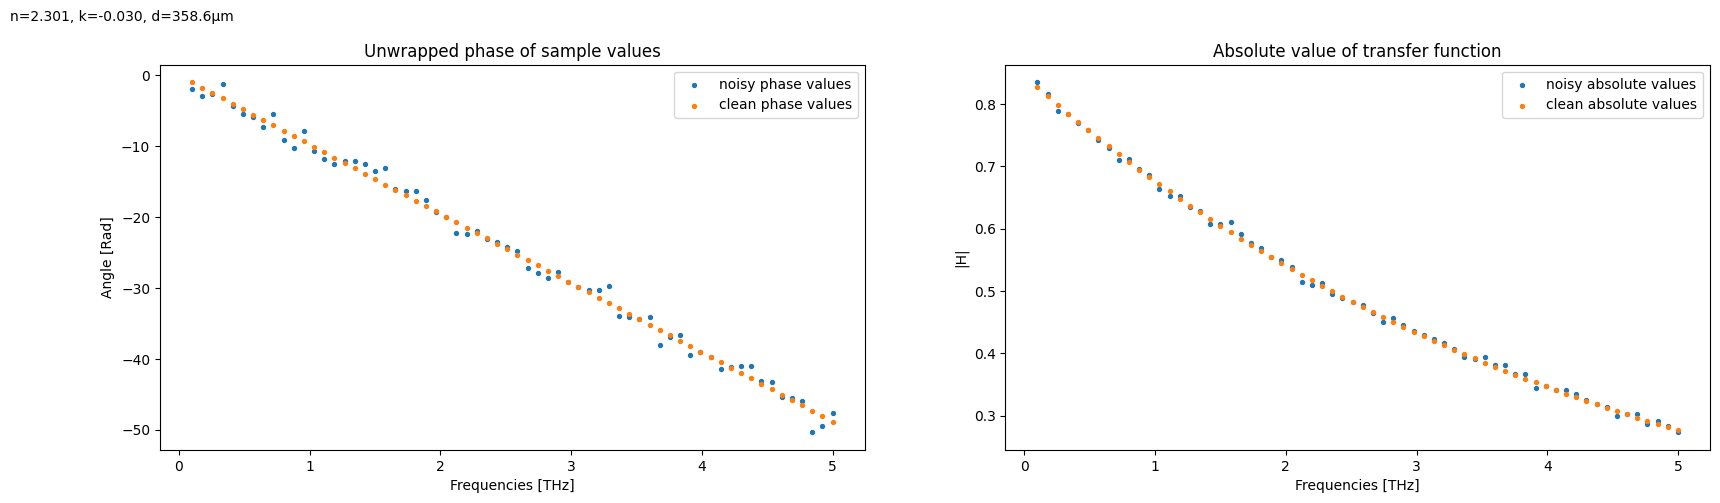

In [3]:
# Plot actual values and noisy signals 
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].scatter(freqs_THz, phi_values, s=8, label='noisy phase values')
axs[0].scatter(freqs_THz, phi_values_clean, s=8, label='clean phase values')
axs[0].set_title('Unwrapped phase of sample values')
axs[0].set_xlabel('Frequencies [THz]')
axs[0].set_ylabel('Angle [Rad]')

axs[1].scatter(freqs_THz, H_values, s=8, label='noisy absolute values')
axs[1].scatter(freqs_THz, H_values_clean, s=8, label='clean absolute values')
axs[1].set_title('Absolute value of transfer function')
axs[1].set_xlabel('Frequencies [THz]')
axs[1].set_ylabel('|H|')

# Annotate with n, k, d values
axs[1].set_ylabel('|H|')

# Add a label at the top-left of the entire figure (outside the subplots)
fig.text(0.05, 0.99, f'n={n:.3f}, k={k:.3f}, d={1e6*d:.1f}µm', 
         verticalalignment='top', horizontalalignment='left', 
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

axs[0].legend()
axs[1].legend()
plt.show()

In [4]:
# Perform grid-search for params
#grid_search(n0=2.0, k0=-0.05, d0=0.0004, H_values=H_values, phi_values=phi_values, freqs_ang=freqs_ang, H_th_function=H_th_function, loss=loss, verbose=True)

## Regular parameterization

Best Parameters: n = 2.3055267333984375, k = -0.02949652075767517


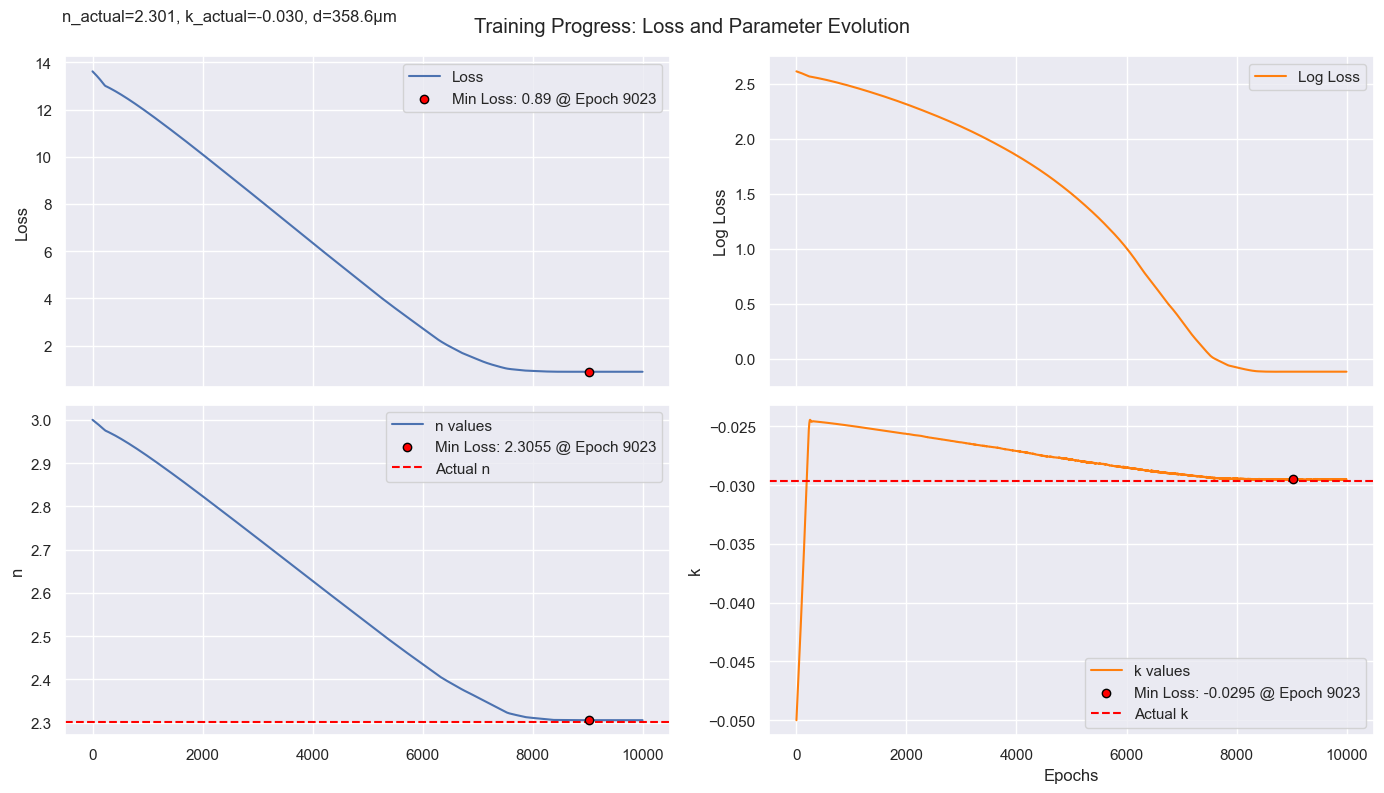

In [5]:
# Initialize model
model = TransferFunctionModel(w_tensor=w_tensor, d=d_actual, ICs=[3,-0.05])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
model.train_model(loss, H_values, phi_values, optimizer=optimizer, epochs=10000, verbose=False)

# Access best parameters after training
print(f"Best Parameters: n = {model.best_params['n']}, k = {model.best_params['k']}")

# Plot training curves
model.plot_training_curves(n_actual, k_actual, d)

Epoch 0: Loss = 13.621763087046055
Epoch 500: Loss = 13.136615383044347
Epoch 1000: Loss = 12.77971066162524
Epoch 1500: Loss = 12.422143632151649
Epoch 2000: Loss = 12.063853130844366
Epoch 2500: Loss = 11.704533438269513
Epoch 3000: Loss = 11.34493722317828
Epoch 3500: Loss = 10.984708475884721
Epoch 4000: Loss = 10.624253330290989
Epoch 4500: Loss = 10.263147545561957
Epoch 5000: Loss = 9.901938318279312
Epoch 5500: Loss = 9.540823716373128
Epoch 6000: Loss = 9.182919988151994
Epoch 6500: Loss = 8.82671645195052
Epoch 7000: Loss = 8.46964634354055
Epoch 7500: Loss = 8.111671599649132
Epoch 8000: Loss = 7.753087831240297
Epoch 8500: Loss = 7.394351771503014
Epoch 9000: Loss = 7.036026580377174
Epoch 9500: Loss = 6.682011742546481
Final n: 2.6264379024505615, Final k: -0.027109531685709953
Best n: 2.626474618911743, Best k: -0.02710804156959057 (Lowest Loss: 6.331918966455097)
Best Parameters: n = 2.626474618911743, k = -0.02710804156959057


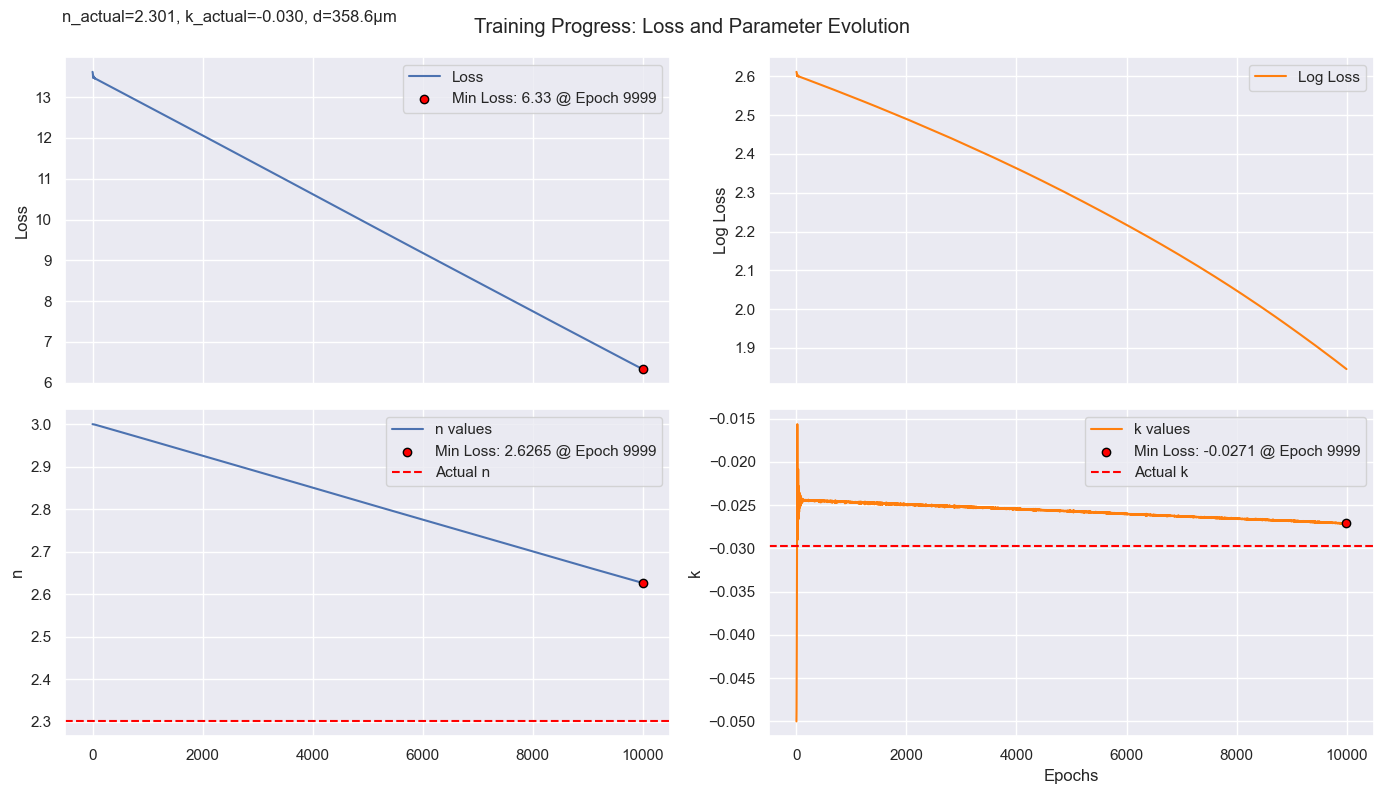

In [6]:
# Test SGD
model2 = TransferFunctionModel(w_tensor=w_tensor, d=d_actual, ICs=[3,-0.05])
optimizer = torch.optim.SGD(model2.parameters(), lr=1e-4, momentum=0.9)

# Train the model
model2.train_model(loss, H_values, phi_values, optimizer=optimizer, epochs=10000, verbose=True)

# Access best parameters after training
print(f"Best Parameters: n = {model2.best_params['n']}, k = {model2.best_params['k']}")

# Plot training curves
model2.plot_training_curves(n_actual, k_actual, d)

## plotting training

In [7]:
# TODO: 
# Test different initial conditions and create fractals?
# Implement min loss search / early stopping / learning schedule.
# Explore n convergence (seems to be over reducing)